In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Principal Component Analysis

### Data Munging
Let's load the data first. Some initial prep is needed. You have to make sure that the index column is not in your dataframe. Then separate the dataframe into the features and the target. We do *not* want to run PCA with cover type!

In [2]:
df = pd.read_csv('train_and_test.csv', index_col=0)
features = df[df.columns[:54]]
target = df['Cover_Type']
features.head()

,Elevation,Aspect,Slope,Horizontal_Dist_To_Water,Vertical_Dist_To_Water,Horizontal_Dist_To_Roadways,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Horizontal_Dist_To_Fire_Points,...,Soiltype31,Soiltype32,Soiltype33,Soiltype34,Soiltype35,Soiltype36,Soiltype37,Soiltype38,Soiltype39,Soiltype40
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,0
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,0


### PCA Take I
Alright, now that stuff is out of the way. Let's do some PCA! So first what happens is that you have a PCA object that takes in some parameters. I am using all default ones right now, but I might change that eventually. 

In [3]:
pca_feat = PCA() # this is the PCA object
pca_feat.fit(features) # fit the PCA object on the features that you have

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

So now we want to see what the explained variances are. I am using seaborn to visualize the variances so I need to mess around with the explained variances a little bit to be able to plug it in neatly to a seaborn function.

In [4]:
explained_variances = pd.DataFrame(pca_feat.explained_variance_ratio_, columns=['variance'])
explained_variances['index'] = range(1, len(explained_variances) + 1)
explained_variances.head()

,variance,index
0,0.662744,1
1,0.307020,2
2,0.017730,3
3,0.008603,4
4,0.003069,5


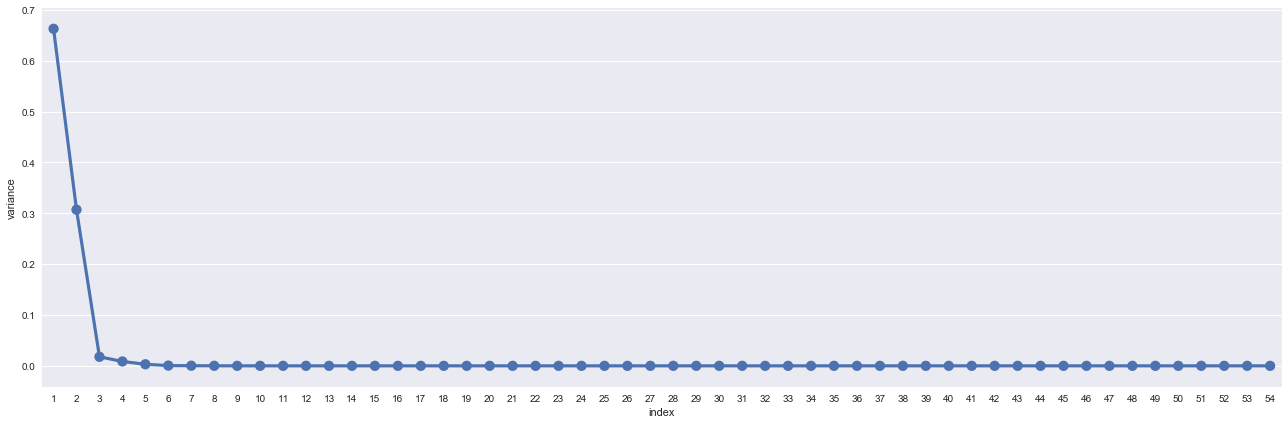

In [5]:
%matplotlib inline
sn.factorplot(x = 'index', y = 'variance', data = explained_variances, size=6, aspect=3)

This plot is very striking. From PCA, it appears we need to use only ~3-4 top PCA features. Let's magnify the image a little bit and zoom in on just 1 - 10.

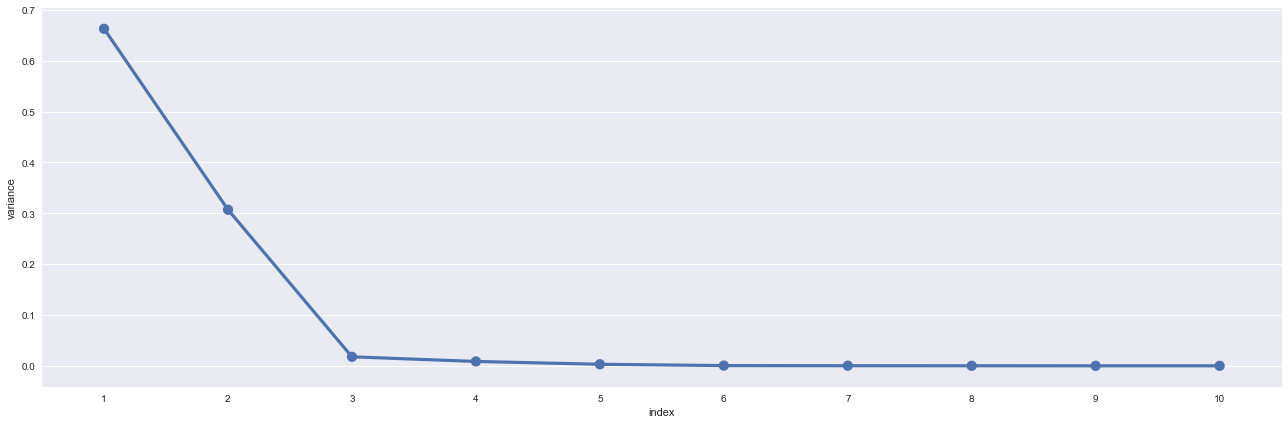

In [6]:
sn.factorplot(x = 'index', y = 'variance', data = explained_variances[:10], size=6, aspect=3)

### Comments for other models
At this point, I am not entirely sure how we would want to go about using these features. One of the problems is that this PCA is run on the whole training dataset. Another thing is that sklearn allows you to pipeline models. This means that you create a 'pipeline' which is a set of data operations that you can chain and then train the entire train_and_test dataset on your pipeline. I am not 100% sure what this means to our testing (not safe) and cross-validation so we should discuss that. I also feel that instead of using the data that I have here, it would be better for you guys to run PCA separately for your models so you can use the pipelining thing, as well as tweaking it based on how you want to cross-validate and so on.

### PCA with KNN:
Now that we know that the first two Principle Components explain 96% of the variance (and the first four ~ 99%), we can combine PCA with KNN. We start by plotting data set projected onto it's first two principle components for visualization purposes.

In [7]:
# PCA:
n_comp = 2
pca_n = PCA(n_components=n_comp)
features_transformed = pca_n.fit_transform(features)

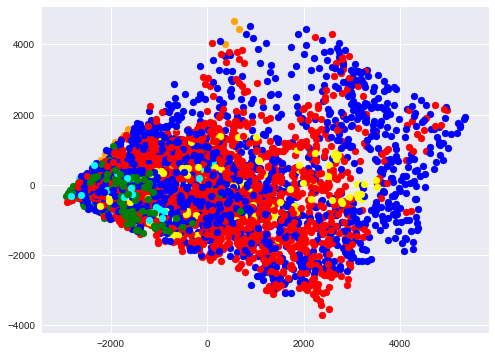

In [8]:
plt.close('all')
trans_feat_plot = plt.figure(figsize=(8,6))
x_vals = features_transformed[::100,0]
y_vals = features_transformed[::100,1]
tar = np.array(target)[::100]-1
colors = ['red', 'blue', 'green', 'magenta', 'orange', 'cyan', 'yellow']
names = ['Type ' + str(i) for i in range(1, 8)]
for i in range(len(x_vals)):
    col = colors[tar[i]]
    lab = names[tar[i]]
    plt.scatter(x_vals[i], y_vals[i], color = col, label=names[tar[i]])

Now we will perform PCA with the first 4 components, and then do KNN on the resulting data. 

In [9]:
# PCA:
n_comp = 4
pca_n = PCA(n_components=n_comp)
features_transformed = pca_n.fit_transform(features)

Now we have projected the data set onto the first 4 principal components. We will separate the data into two sets: one for training (i.e. creating the neighbors), and the other for testing:

In [10]:
np.random.seed(1) # seed random number generator
# Separate into training (80%) and testing (20%):
msk = np.random.rand(len(features_transformed)) < 0.8
train_features = features_transformed[msk]
train_target = target[msk]
test_features = features_transformed[~msk]
test_target = target[~msk]

Perform knn:

In [11]:
# KNN:
k = 5
knn = KNeighborsClassifier(n_neighbors= k)
knn.fit(train_features, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [12]:
predicted = knn.predict(test_features)
actual = np.array(test_target)

Compute success rate:

In [13]:
result = [None]*len(actual)
for i in range(len(actual)):
    result[i] = (predicted[i]==actual[i])

correct_count = [i for i in result if i==True]
correct_rate = float(len(correct_count))/len(result)
correct_rate

0.9263083985957332